In [2]:
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline 

# Numerical Solution of a Two-Dimensional Supersonic Flow: Prandtl-Meyer Expansion Wave
This notebook looks that what hppends when a nonviscous flow goes over an expansion corner at a supersonic velocity. We will be implmenting a space marching solution instead of a time marching solution. This example is taken from chapter 8 of John D. Anderson's book, *Computational Fluid Dynamics: The Basics with Applications*.

## Introduction: Physical Problem and Analytical Solution

A Prandtl-Meyer expansion wave is made up of an infinite number of infinitely weak shcokwaves that fan out around a corner. This is caused by the expansion of a compressible fluid at supersonic speeds. The leading edge of the fan makes an angle $\mu_1$ wtih respect to the upsttream flow and an agle $\mu_2$ with respect to the downstream flow. Analytically, these values are defined as

$\mu_1 = sin^{-1}\frac{1}{M_1}$

$\mu_2 = sin^{-1}\frac{1}{M_2}$

$M_1$ and $M_2$ are the upstream and downsteam mach numbers,respectively. 

The flow through the fan is isentropic and we know that as a supersonic gas expands, the velocity increases as the temperature and density decrease. The flow before the fan is parallel to the wall boundary and after the expansion fan, the flow is parallel to the declined ramp. All of these flow characteristics hold true for the mjority of the flow except for the corner of the expansion fan. At this point, all of the arms of the fan branch out causing a disconinuous change in the flow direction. This will cause numerical problems if not hadled correctly. 

For a calorically perfect gas, there is an analytical solution for that point based on the defelction angle of the ramp which we will call $\theta$. The simple relation is calculated as such. 

$f_2 = f_1 + \theta$

The value of $f$ can be calculated with the Prandtl-Meyer function below

$f = \sqrt{\frac{\gamma + 1}{\gamma - 1}} tan^{-1}\sqrt{\frac{\gamma-1}{\gamma+1}(M^2 -1 )}-tan^{-1}\sqrt{M^2-1}$

This relation allows you to calculate the mach number if oyu know the upstream mach number and the angle of the downward slope $\theta$.

Once we have the mach number, we can use the isentropic flow relations to get the values for pressure and temperature downstream. 

$p_2 = p_1 \Big \{ \frac{1+[(\gamma-1)/2]M_1^2}{1+[(\gamma-1)/2]M_2^2}\Big \} ^{\gamma / (\gamma -1)}$

$T_2 = T_1  \frac{1+[(\gamma-1)/2]M_1^2}{1+[(\gamma-1)/2]M_2^2}$

and we can calculate density using the following equation

$\rho_2 = \frac{p_2}{RT_2}$

## Numerical Solution 

We will be using a space marching solution to solve this numerically. That means that instead of marching through steps of time, we will begin at the inflow boundary condition and progress down stream by increments of $\Delta x$. We will still be using MacCormack's method, but with space (in x-direction) instead of time. 
### Governing Equations
For a steady state Euler flow in two dimensions,we will use the strong conservation form as displayed below.

$\frac{\partial F}{\partial x} = J - \frac{\partial G}{\partial y}$

The values of $F$ and $G$ are vectors that represent the flow variables as such.

$F_1 = \rho u$

$F_2 = \rho u^2 + p$

$F_3 = \rho u v$

$F_4 = \rho u \Big(e+\frac{V^2}{2}\Big)+pu$

$G_1 = \rho v$

$G_2 = \rho uv$

$G_3 = \rho v^2 +p$

$G_4 = \rho v \Big(e+\frac{V^2}{2}\Big)+pv$


We can simplify the energy equations for $F$ and $G$ with the following identity of a calorically perfect gas.

$e = c_v T = \frac{RT}{\gamma -1} = \frac{1}{\gamma - 1} = \frac{1}{\gamma -1}\frac{p}{\rho}$

$F_4 = \rho u \Big( \frac{1}{\gamma-1}\frac{p}{\rho} + \frac{u^2 + v^2}{2}\Big) + pu$

$ = \frac{1}{\gamma -1}pu + \rho u \frac{u^2 + v^2}{2} + pu$

Finally we have a form of the equation without e:

$F_4 = \frac{\gamma}{\gamma -1}pu + \rho u \frac{u^2 + v^2}{2}$

Doing the same thing for $G_4$, we get

$G_4 = \frac{\gamma}{\gamma -1}pv + \rho v \frac{u^2 + v^2}{2}$

Because we are not running this simulation with a time marching solution, we do not have a $U$ vector to ectract our primative variables. Instead we will be decoded from the flux variables $F$. We can use the following equations to do so

$\rho = \frac{-B + \sqrt{B^2 - 4AC}}{2A}$

$A = \frac{F^2_3}{2F_1} - F_4$

$B = \frac{\gamma}{\gamma - 1}F_1 F_2$

$C = -\frac{\gamma +1}{2(\gamma -1)}F_1^3$

$u = \frac{F_1}{\rho}$

$v = \frac{F_3}{F_1}$

$p = F_2 - F_1 u$

$T = \frac{p}{\rho R}$


As for the calculation of the $G$ vector values, we can get them in terms of $F$ instead of the primative variables. 

$G_1 = \rho v = \rho \frac{F_3}{F_1}$

$G_2 = F_3$

$G_3 = \rho v^2 + p = \rho \Big(\frac{F_3}{F_1}\Big)^2 + p$

$p = F_2 - \rho u^2 = F_2 - \frac{F_1^2}{\rho}$

$G_3 = \rho \Big(\frac{F_3}{F_1}\Big)^2 + F_2 - \frac{F_1^2}{\rho}$

$G_4 =\frac{\gamma}{\gamma -1} pv + \rho v \frac{u^2 + v^2}{2} = \frac{\gamma}{\gamma -1} \Big(F_2 - \frac{F_1^2}{\rho}\Big)\frac{F_3}{F_1}+\frac{\rho}{2} \frac{F_3}{F_1}\Big[\Big(\frac{F_1}{\rho}\Big)^2 + \Big(\frac{F_3}{F_1}\Big)^2\Big]$

Before we begin setting upour simulation, we need to consider our geometry. Below is a plot of the geometry in the physical plane.

Text(0, 0.5, 'y')

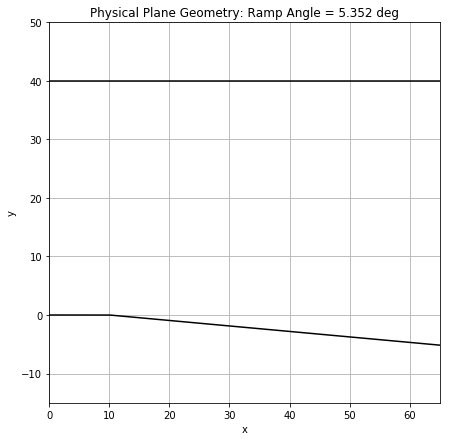

In [3]:
x = np.linspace(0,65,200)
h = np.zeros(200)
index = 0
for i in x:
    if i <10:
        h[index] = 40
    else:
        h[index] = 40+math.tan(0.09341002)*(x[index]-10) # make sure to convert to radians
    
    index = index +1
#plot geometry
plt.figure(figsize=(7,7))
plt.plot(x,np.ones(200)*40,'black')
plt.plot(x,40-h,'black')
plt.ylim([-15,50])
plt.xlim([0,65])
plt.grid()
plt.title('Physical Plane Geometry: Ramp Angle = 5.352 deg')
plt.xlabel('x')
plt.ylabel('y')

This geometry does not work with a purely structured cartesian grid. In order to account for the declined ramp, we need to use a transformation that will show up in our governing equations.Here we will use a boundary fitted coordiate system with variables $\eta$ and $\zeta$. The symbol eta $\eta$ represents the spacing up and down in the physical plane and the symbol $\zeta$ represents the spacing left and right in the physical plane. The transformation from $(x,y)$ to  $(\zeta,\eta)$ will be as follows

$\zeta = x$

$\eta = \frac{y-y_s (x)}{h(x)}$

Where $y_s (x)$ is the y location of the lower boundary surface, and $h(x)$ is the distance between the top and bottom boundaries. This transformation creates a nice cratesian mesh in the $(\zeta,\eta)$ plane where $\zeta$ is between 0 and L and $\eta$ varies from 0 to 1.0.

With this transformation, we also have adjust our governing equations. The following equations show the proper transformation.

$\frac{\partial}{\partial x} = \frac{\partial}{\partial \zeta} \Big( \frac{\partial \zeta}{\partial x}\Big) + \frac{\partial}{\partial \eta}\Big( \frac{\partial \eta}{\partial x}\Big)$

$\frac{\partial}{\partial y} = \frac{\partial}{\partial \zeta} \Big( \frac{\partial \zeta}{\partial y}\Big) + \frac{\partial}{\partial \eta}\Big( \frac{\partial \eta}{\partial y}\Big)$

Pluggin in our geometric transformation into the derivative transformation, we get the following metrics

$\frac{\partial \zeta}{\partial x} = 1$

$\frac{\partial \zeta}{\partial y} = 0$

$\frac{\partial \eta}{\partial x} = -\frac{1}{h} \frac{dy_s}{dx} - \frac{\eta}{h}\frac{\partial h}{\partial x}$

$\frac{\partial \eta}{\partial y} = \frac{1}{h}$

The one complicated term is $\partial \eta /\partial x$, so let's transform it into something simpler to deal with. For the x location of the corner of the expasion wave set to value $E$.

For $x \leq E$:

$y_s = 0$

$h = const$

For $x \geq E$:

$y_s = -(x-E)tan\theta$

$h = H +(x-E)tan\theta$

Differentiating these expressions, we get the following


For $x \leq E$:

$\frac{dy_s}{dx} = 0$

$\frac{dh}{dx} = 0$

For $x \geq E$:

$\frac{dy_s}{dx} = -tan\theta$

$\frac{dh}{dx} = tan\theta$

So the metric of $\partial \eta /\partial x$ can be described as:

$\frac{\partial \eta}{\partial x} = 0$ for $x \leq E$

$\frac{\partial \eta}{\partial x} = (1-\eta)\frac{tan\theta}{h}$ for $x \geq E$


Plugging these metrics back into the derivative transformation, we get that 

$\frac{\partial}{\partial x} =\frac{\partial }{\partial \zeta} + \Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial}{\partial eta}$

$\frac{\partial}{\partial y} = \frac{1}{h}\frac{\partial }{\partial \eta}$

With $J=0$ we can write our govering equaiton.

$\frac{\partial F}{\partial x} = - \frac{\partial G}{\partial y}$

Now we we implement the transformation derivative to put our equation in the computational plane. 

$\frac{\partial F}{\partial \zeta} + \Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F}{\partial \eta} = -\frac{1}{h}\frac{\partial G}{\partial \eta}$

or rewritten as

$\frac{\partial F}{\partial \zeta} = - \Big[\Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F}{\partial \eta}+\frac{1}{h}\frac{\partial G}{\partial \eta}\Big]$


To put this in terms of our flow equations, we have

Continuity:     $\frac{\partial F_1}{\partial \zeta} = - \Big[\Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F_1}{\partial \eta}+\frac{1}{h}\frac{\partial G_1}{\partial \eta}\Big]$

x momentum:     $\frac{\partial F_2}{\partial \zeta} = - \Big[\Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F_2}{\partial \eta}+\frac{1}{h}\frac{\partial G_2}{\partial \eta}\Big]$

y momentum:     $\frac{\partial F_3}{\partial \zeta} = - \Big[\Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F_3}{\partial \eta}+\frac{1}{h}\frac{\partial G_3}{\partial \eta}\Big]$

Energy:     $\frac{\partial F_4}{\partial \zeta} = - \Big[\Big(\frac{\partial \eta}{\partial x}\Big)\frac{\partial F_4}{\partial \eta}+\frac{1}{h}\frac{\partial G_4}{\partial \eta}\Big]$

### The Setup

#### Artificial Viscosity

As we prepare to solve our problem, we need to address two big topics: artificial viscosity and boundary conditions. The artificial viscosity will be handled in the same fashion as the nozzle flow problem and will be represented as such.


$S'^t_i = \frac{C_y |(p')^{t'}_{i+1} - 2(p')^{t'}_i +(p')^{t'}_{i-1}|}{(p')^{t'}_{i+1} + 2(p')^{t'}_i +(p')^{t'}_{i+1}}(F^{t'}_{i+1}-2F^{t'}_{i}+F^{t'}_{i-1})$

This value will then be added to the calculation of the predictor and corrector step.

#### Boundary Conditions

As for the boundary condition, we want to enforce that at the wall there is no flow normal to the wall. We do this by uodating our primitive variables to ones that represent a flow that only has a tanget component of velocity to the wall. We do thsi by using Abbett's method. First first step is to calculate the angle the flow has with the wall and the mach number at the current node with the following equations

$\phi_1 = tan^{-1}\frac{v_1}{u_1}$

$(M_1)_{cal} = \frac{ \sqrt{(u_1)_{cal}^2+(v_1)_{cal}^2} }{(a_1)_{cal}}$

Then we use the Prandtl-Meyer function to get the value for $f_{cal}$

$f_{cal} = \sqrt{\frac{\gamma + 1}{\gamma - 1}} tan^{-1}\sqrt{\frac{\gamma-1}{\gamma+1}(M_{cal}^2 -1 )}-tan^{-1}\sqrt{M_{cal}^2-1}$

Then we correct the value of $f$ with $\phi$

$f_{act} = f_{cal}+\phi_1$

Then using the same equation used to et $f$, we backout the value for our new mach number. 

Lastly, we use the following equations to get the rest of the primitive variables


$p_2 = p_1 \Big \{ \frac{1+[(\gamma-1)/2]M_1^2}{1+[(\gamma-1)/2]M_2^2}\Big \} ^{\gamma / (\gamma -1)}$

$T_2 = T_1  \frac{1+[(\gamma-1)/2]M_1^2}{1+[(\gamma-1)/2]M_2^2}$

$\rho_2 = \frac{p_2}{RT_2}$

There is one more thing to look out for when we are calculating the BC's and that is the change in slope of the ramp. After the horizontal part, the ramp changes to a decline. We account for this in the calculation of $f_{act}$

$f_{act} = f_{cal}+\phi_2$

$\psi = tan^{-1}\frac{|v_2|}{u_2}$

$\phi_2 = \theta - \psi$


As we prepare to run our simulation, let us define some functions that will help simplify our code later down the line. The first few funcitons will help with conversions. The following functions will help reduce repeated code and help prevent mistakes by reducing clutter. Additionally, by splitting up our code into small function we can test them individually and trouble shoot each part of the code with known input and output. 

In [4]:
def primatives2F(u,v,rho,pres,gamma):
    # Converting primitive variables to F vector
    F1 = rho*u
    F2 = rho*(u**2) + pres
    F3 = rho * u * v
    F4 = ( (gamma/(gamma-1)) * pres * u ) + ( rho * u * ((u**2 + v**2)/2) )
    return F1,F2,F3,F4

def F2G(F1,F2,F3,F4):
    # Calculate F values to G
    gamma=1.4
    A = ( (F3**2) / (2*F1) ) - F4
    B = (gamma/ (gamma-1) ) * F1 * F2
    C = -( (gamma+1) / ( 2 * (gamma-1) ) ) * F1**3
    rho = (-B+( ( (B**2) - 4*A*C )**0.5 ) ) / (2*A)
    G1 = rho*(F3/F1)
    G2 = F3
    G3 = (rho*(F3/F1)**2) + F2 - ((F1**2)/rho)
    G4 = (gamma/(gamma-1)) * ( F2- ((F1**2)/rho) )  * (F3/F1) + ( (rho/2) * (F3/F1) * ( ((F1/rho)**2) + ((F3/F1)**2) ) )
    return G1,G2,G3,G4

def F2Primatives(F1,F2,F3,F4,gamma):
    # Extract primitive variables from F
    A = ( (F3**2) / (2*F1) ) - F4
    B = (gamma/ (gamma-1) ) * F1 * F2
    C = -( (gamma+1) / ( 2 * (gamma-1) ) ) * F1**3
    rho = (-B+( ( (B**2) - 4*A*C )**0.5 ) ) / (2*A)
    u = F1/rho
    v = F3/F1
    pres = F2-F1*u
    return u,v,rho,pres

The next set of function will help us calcualte our boundary conditions. There are a few steps to the BC calcualtion process. First we have to get the corrected mach value. To do this, we use the equations stated above to adjust the vlaue for $f$. However, we need to back out the coresponding mach number with the function: backOutMach. In this function, we iterate until we converge on a mach number that gets us close to our desired $f$. Once we have the corrected mach number, we extract the rest of the primatives with the mach2Primitives function. 

In [5]:
def wallBC(u,v,rho,pres,x,theta,gamma,R):
    # Calculate phi depending on x location
    if x <= 10:
        phi = math.atan(v/u)
    else:
        phi = theta - math.atan(abs(v)/u)
    # Calculate corrected value
    temp = pres/(rho*R)
    a =((gamma*pres/rho)**0.5)
    MCal = math.sqrt(u**2 + v**2)/a
    fCal = math.sqrt((gamma+1)/(gamma-1)) * math.atan(math.sqrt( ( (gamma-1)/(gamma+1) ) * (MCal**2 -1) )) - math.atan(math.sqrt((MCal**2) -1)) 
    fAct = fCal+phi
    Mact = backOutMach(fAct,gamma)
    pAct,TAct,rhoAact = mach2Primitives(MCal,Mact,pres,temp,R,gamma)
    vNew = -u*math.tan(theta)# v is the tan(theta) component of u
    uNew = u # u is kept the same 
    return uNew,vNew,rhoAact,pAct

def backOutMach(f,gamma):
    # given some value of f, we need to backout M
    # f input in deg converted to rad
    guessM = 4
    delta = 1
    while abs(delta)>0.0000001:
        fGuess = math.sqrt((gamma+1)/(gamma-1)) * math.atan(math.sqrt( ( (gamma-1)/(gamma+1) ) * (guessM**2 -1) )) - math.atan(math.sqrt(guessM**2 -1)) 
        delta = fGuess - f
        guessM = guessM - delta*0.1
    return guessM

def mach2Primitives(Mcal,Mact,pcal,Tcal,R,gamma):
    # Calculate primitives from mach numbers and new p & T
    top = 1 + ((gamma-1)/2)*Mcal**2
    bottom = 1 + ((gamma-1)/2)*Mact**2
    pAct = pcal * (top/bottom) ** ( gamma/(gamma-1) )
    TAct = Tcal * (top/bottom)
    rhoAact = pAct/(R*TAct)
    return pAct,TAct,rhoAact

### Iteration Scheme

In [6]:
def marchInX(u,v,rho,pres,gamma,dEtadx,deltaEta,deltaZeta,h,cVisc,x,theta,R):
    """
    This function marches in the x-direction for 
    a space marching solution of a supersonic P-M 
    expansion fan problem
    u - velocity in x
    v - velocity in y 
    rho - density
    pres - pressure
    gamma - heat coefficient ratio (1.4 for air)
    dEtadx - partial eta / partial x
    deltaEta - step size of eta (analog to y but in computational plane)
    deltaZeta - step size in zeta (analog to x but in computational plane)
    cVisc - artificial viscosity coefficient
    h - distance between top of gid and wall BC
    x - x location of current node
    theta - angle of ramp
    R - gas constant 
    """
    numPts = 41
    F1,F2,F3,F4 = primatives2F(u,v,rho,pres,gamma)
    G1,G2,G3,G4 = F2G(F1,F2,F3,F4)
    
    ##########################
    ##### Predictor Step #####
    ##########################
    
    # Initialize array for rate of change for predictor step
    dF1dZeta = np.zeros(numPts)
    dF2dZeta = np.zeros(numPts)
    dF3dZeta = np.zeros(numPts)
    dF4dZeta = np.zeros(numPts)
    # Initialize array for first forward predictor step
    F1Bar = np.zeros(numPts)
    F2Bar = np.zeros(numPts)
    F3Bar = np.zeros(numPts)
    F4Bar = np.zeros(numPts)
    G1Bar = np.zeros(numPts)
    G2Bar = np.zeros(numPts)
    G3Bar = np.zeros(numPts)
    G4Bar = np.zeros(numPts)
    # Initialize array for artificial viscosity
    sf1 = np.zeros(numPts)
    sf2 = np.zeros(numPts)
    sf3 = np.zeros(numPts)
    sf4 = np.zeros(numPts)
    # Initialize array for parimitives forward step
    uBar    = np.zeros(numPts)
    vBar    = np.zeros(numPts)
    rhoBar  = np.zeros(numPts)
    presBar = np.zeros(numPts)

    for j in range(0,numPts-1):
        dF1dZeta[j] = ( dEtadx[j] * ( (F1[j] - F1[j+1]) / (deltaEta) ) ) + (1/h) * ( (G1[j] - G1[j+1]) / (deltaEta) )
        dF2dZeta[j] = ( dEtadx[j] * ( (F2[j] - F2[j+1]) / (deltaEta) ) ) + (1/h) * ( (G2[j] - G2[j+1]) / (deltaEta) )
        dF3dZeta[j] = ( dEtadx[j] * ( (F3[j] - F3[j+1]) / (deltaEta) ) ) + (1/h) * ( (G3[j] - G3[j+1]) / (deltaEta) )
        dF4dZeta[j] = ( dEtadx[j] * ( (F4[j] - F4[j+1]) / (deltaEta) ) ) + (1/h) * ( (G4[j] - G4[j+1]) / (deltaEta) )
        
        sf1[j] = cVisc*(abs(pres[j+1]-2*pres[j]+pres[j-1])/(pres[j+1]+2*pres[j]+pres[j-1])) * (F1[j+1]-2*F1[j]+F1[j-1])
        sf2[j] = cVisc*(abs(pres[j+1]-2*pres[j]+pres[j-1])/(pres[j+1]+2*pres[j]+pres[j-1])) * (F2[j+1]-2*F2[j]+F2[j-1])
        sf3[j] = cVisc*(abs(pres[j+1]-2*pres[j]+pres[j-1])/(pres[j+1]+2*pres[j]+pres[j-1])) * (F3[j+1]-2*F3[j]+F3[j-1])
        sf4[j] = cVisc*(abs(pres[j+1]-2*pres[j]+pres[j-1])/(pres[j+1]+2*pres[j]+pres[j-1])) * (F4[j+1]-2*F4[j]+F4[j-1])
        
        if j==0:
            F1Bar[j] =  F1[j] + dF1dZeta[j]*deltaZeta + sf1[j]
            F2Bar[j] =  F2[j] + dF2dZeta[j]*deltaZeta + sf2[j]
            F3Bar[j] =  F3[j] + dF3dZeta[j]*deltaZeta + sf3[j]
            F4Bar[j] =  F4[j] + dF4dZeta[j]*deltaZeta + sf4[j]
        else:
            F1Bar[j] =  F1[j] + dF1dZeta[j]*deltaZeta + sf1[j]
            F2Bar[j] =  F2[j] + dF2dZeta[j]*deltaZeta + sf2[j]
            F3Bar[j] =  F3[j] + dF3dZeta[j]*deltaZeta + sf3[j]
            F4Bar[j] =  F4[j] + dF4dZeta[j]*deltaZeta + sf4[j]

        G1Bar[j],G2Bar[j],G3Bar[j],G4Bar[j] = F2G(F1Bar[j],F2Bar[j],F3Bar[j],F4Bar[j])
        uBar[j],vBar[j],rhoBar[j],presBar[j] = F2Primatives(F1Bar[j],F2Bar[j],F3Bar[j],F4Bar[j],gamma)
    """
    !!!CAUTION!!!
    One thing to look out for here is that node 41 did not get any bar values
    because there is no node to predict to, but we know from our BC's that
    we will just set it to our initial condition values    
    """    
    presBar[numPts-1]= pres[numPts-1]
    F1Bar[numPts-1] = F1[numPts-1]
    F2Bar[numPts-1] = F2[numPts-1]
    F3Bar[numPts-1] = F3[numPts-1]
    F4Bar[numPts-1] = F4[numPts-1]
    
    ##########################
    ##### Corrector Step #####
    ##########################
    
    # Intitialize array for rate of change corrector step
    dF1dZetaBar = np.zeros(numPts)
    dF2dZetaBar = np.zeros(numPts)
    dF3dZetaBar = np.zeros(numPts)
    dF4dZetaBar = np.zeros(numPts)
    # Averaged rate of change (corrector + predictor)/2
    dF1dAvg = np.zeros(numPts)
    dF2dAvg = np.zeros(numPts)
    dF3dAvg = np.zeros(numPts)
    dF4dAvg = np.zeros(numPts)
    # Viscosity value for corrector step
    sf1Bar = np.zeros(numPts)
    sf2Bar = np.zeros(numPts)
    sf3Bar = np.zeros(numPts)
    sf4Bar = np.zeros(numPts)
    
    for j in range(0,numPts-1):
        if j ==0:# forward step for node 1 due to lack of node before it
            dF1dZetaBar[j] = ( dEtadx[j] *( (F1Bar[j] - F1Bar[j+1]) / (deltaEta) ) ) + (1/h) * ( (G1Bar[j] - G1Bar[j+1]) / (deltaEta) )
            dF2dZetaBar[j] = ( dEtadx[j] *( (F2Bar[j] - F2Bar[j+1]) / (deltaEta) ) ) + (1/h) * ( (G2Bar[j] - G2Bar[j+1]) / (deltaEta) )
            dF3dZetaBar[j] = ( dEtadx[j] *( (F3Bar[j] - F3Bar[j+1]) / (deltaEta) ) ) + (1/h) * ( (G3Bar[j] - G3Bar[j+1]) / (deltaEta) )
            dF4dZetaBar[j] = ( dEtadx[j] *( (F4Bar[j] - F4Bar[j+1]) / (deltaEta) ) ) + (1/h) * ( (G4Bar[j] - G4Bar[j+1]) / (deltaEta) )
        else:# the rest of the nodes (excluding the last one get a rearwards step)
            dF1dZetaBar[j] = ( dEtadx[j] *( (F1Bar[j-1] - F1Bar[j]) / (deltaEta) ) ) + (1/h) * ( (G1Bar[j-1] - G1Bar[j]) / (deltaEta) )
            dF2dZetaBar[j] = ( dEtadx[j] *( (F2Bar[j-1] - F2Bar[j]) / (deltaEta) ) ) + (1/h) * ( (G2Bar[j-1] - G2Bar[j]) / (deltaEta) )
            dF3dZetaBar[j] = ( dEtadx[j] *( (F3Bar[j-1] - F3Bar[j]) / (deltaEta) ) ) + (1/h) * ( (G3Bar[j-1] - G3Bar[j]) / (deltaEta) )
            dF4dZetaBar[j] = ( dEtadx[j] *( (F4Bar[j-1] - F4Bar[j]) / (deltaEta) ) ) + (1/h) * ( (G4Bar[j-1] - G4Bar[j]) / (deltaEta) )
        
        sf1Bar[j] = cVisc*(abs(presBar[j+1]-2*presBar[j]+presBar[j-1])/(presBar[j+1]+2*presBar[j]+presBar[j-1])) * (F1Bar[j+1]-2*F1Bar[j]+F1Bar[j-1])
        sf2Bar[j] = cVisc*(abs(presBar[j+1]-2*presBar[j]+presBar[j-1])/(presBar[j+1]+2*presBar[j]+presBar[j-1])) * (F2Bar[j+1]-2*F2Bar[j]+F2Bar[j-1])
        sf3Bar[j] = cVisc*(abs(presBar[j+1]-2*presBar[j]+presBar[j-1])/(presBar[j+1]+2*presBar[j]+presBar[j-1])) * (F3Bar[j+1]-2*F3Bar[j]+F3Bar[j-1])
        sf4Bar[j] = cVisc*(abs(presBar[j+1]-2*presBar[j]+presBar[j-1])/(presBar[j+1]+2*presBar[j]+presBar[j-1])) * (F4Bar[j+1]-2*F4Bar[j]+F4Bar[j-1])

        dF1dAvg[j] = 0.5*(dF1dZetaBar[j]+dF1dZeta[j]) 
        dF2dAvg[j] = 0.5*(dF2dZetaBar[j]+dF2dZeta[j]) 
        dF3dAvg[j] = 0.5*(dF3dZetaBar[j]+dF3dZeta[j]) 
        dF4dAvg[j] = 0.5*(dF4dZetaBar[j]+dF4dZeta[j]) 
        if j==0:
            F1[j] = F1[j] + dF1dAvg[j]*deltaZeta + sf1Bar[j]
            F2[j] = F2[j] + dF2dAvg[j]*deltaZeta + sf2Bar[j]
            F3[j] = F3[j] + dF3dAvg[j]*deltaZeta + sf3Bar[j]
            F4[j] = F4[j] + dF4dAvg[j]*deltaZeta + sf4Bar[j]
        else:
            F1[j] = F1[j] + dF1dAvg[j]*deltaZeta + sf1Bar[j]
            F2[j] = F2[j] + dF2dAvg[j]*deltaZeta + sf2Bar[j]
            F3[j] = F3[j] + dF3dAvg[j]*deltaZeta + sf3Bar[j]
            F4[j] = F4[j] + dF4dAvg[j]*deltaZeta + sf4Bar[j]
        # Extract primitives
        u[j],v[j],rho[j],pres[j]= F2Primatives(F1[j],F2[j],F3[j],F4[j],gamma)
        
    """At this point, we have all of the updated 
       values for our flow except the boundary 
       conditions. The top boundary condition will 
       just be the free stream, but we will need to
       do some calculations for the wall BC. Because 
       we never updated any value for the Nth node,
       the BC is automatically enforced."""
    u[0],v[0],rho[0],pres[0] =  wallBC(u[0],v[0],rho[0],pres[0],x,theta,gamma,R)
    
    return u,v,rho,pres

### Running the Solution and Results

In [7]:
def main(cCFL,cVisc):
    # Flow variables
    gamma = 1.4
    R=287
    # Set initial data line
    u = np.ones([41,1])*678
    v = np.zeros([41,1])
    rho = np.ones([41,1])*1.23
    pres = np.ones([41,1])*101000
    mach = np.ones([41,1])*2
    x=0
    xValues = np.zeros([1,1])
    xValues[0] = x
    yValues = np.zeros([41,1])
    yValues[:,0] = np.transpose(np.linspace(0,40,41))
    
    # Initialize space for updated value arrays
    uNew = np.zeros([41,1])
    vNew = np.zeros([41,1])
    rhoNew = np.zeros([41,1])
    presNew = np.zeros([41,1])
    thetaFreeStream = np.zeros(41)
    mu = np.zeros(41)
    bottom1 = np.zeros(41)
    bottom2 = np.zeros(41)
    i=0
    while x<=65: # 65 is the x length of our grid
        # Calculate h
        if x<=10:
            # Calculate h
            h = 40 
            theta = 0
            dEtadx = np.zeros(41)
        else: # ramp starts at x=10
            h = 40+math.tan(0.09341002)*(x-10)
            theta = 0.09341002
            eta = np.linspace(0,1,41) 
            dEtadx = (1-eta)*math.tan(theta)/h
        
        #Calculate y values for post processing
        y = np.zeros([41,1])
        y[:,0] =  np.transpose(np.linspace(40-h,40,41))
        
        # Calculate deltaEta
        deltaEta = 1/40
        
        # Calculate deltaZeta
        deltaY = h/40
        for k in range(0,41):
            thetaFreeStream[k] = math.atan(v[k,i]/u[k,i])
            mu[k]  = math.asin(1/mach[k,i])
            bottom1[k] = abs(math.tan(thetaFreeStream[k]+mu[k]))
            bottom2[k] = abs(math.tan(thetaFreeStream[k]-mu[k]))  
        deltaZeta1 = cCFL*(deltaY/(bottom1.max()))
        deltaZeta2 = cCFL*(deltaY/(bottom2.max()))
        deltaZeta = deltaZeta2
        if deltaZeta1<deltaZeta2:
            deltaZeta = deltaZeta1
        
        # Solve for next step
        uNew[:,0],vNew[:,0],rhoNew[:,0],presNew[:,0] = marchInX(u[:,i],v[:,i],rho[:,i],pres[:,i],gamma,dEtadx,deltaEta,deltaZeta,h,cVisc,x,theta,R)
        
        # Append results of next step to result array
        u = np.append(u,uNew,1)
        v = np.append(v,vNew,1)
        rho = np.append(rho,rhoNew,1)
        pres = np.append(pres,presNew,1)
        machNew =((uNew**2 + vNew**2)**0.5)/((gamma*presNew/rhoNew)**0.5)
        mach = np.append(mach,machNew,1)

        xValues = np.append(xValues,x)
        yValues = np.append(yValues,y,1)
        
        
        # Update x and i 
        x=x+deltaZeta
        i=i+1
    print('Done.')
    return u,v,rho,pres,mach,xValues,yValues

In [8]:
u,v,rho,pres,mach,xValues,yValues = main(0.5,0.62)

Done.


With the simulation complete, we have the results for each point in our grid. For these conditions, the x axis was broken into 81 nodes so in total, this simulation had 3,321 grid points! Compared to most comercial solvers, this is very coarse, but for an beginning CFD researcher, this is leaps and bounds ahead of a 41 node 1-D simulation.
The most comprihensive way to plot our results is to display the 2D mesh with contour lines showing pressure and quivers showing the direction of the flow at each node. To do this, we will use the contourf and quiver functions from the matplotlib library. 


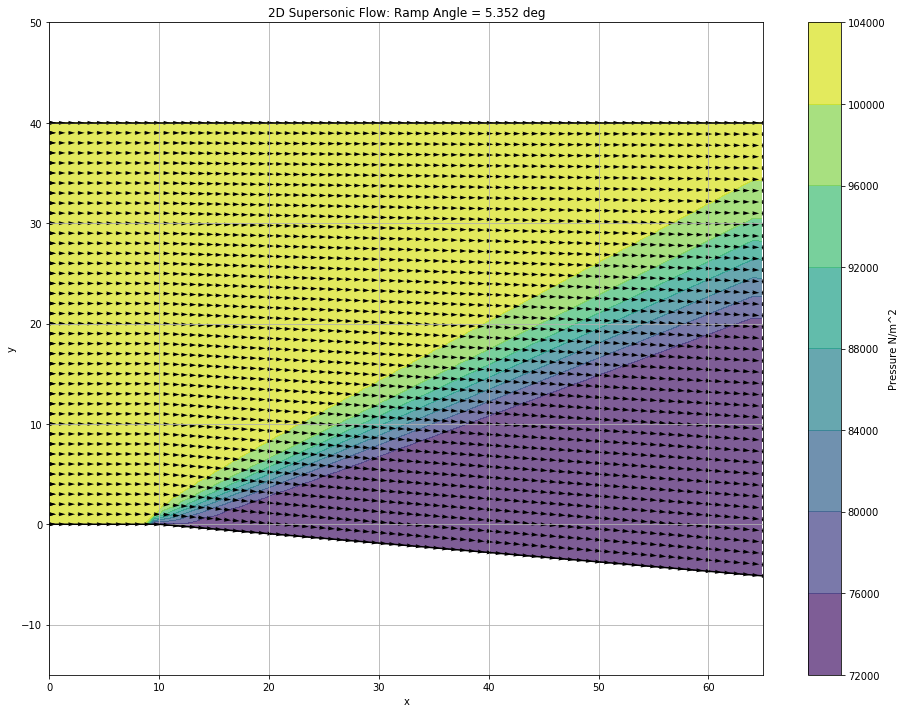

In [9]:
x = np.linspace(0,65,200)
h = np.zeros(200)
index = 0
for i in x:
    if i <10:
        h[index] = 40
    else:
        h[index] = 40+math.tan(0.09341002)*(x[index]-10)
    index = index +1
#plot geometry
plt.figure(figsize=(16,12))
plt.plot(x,np.ones(200)*40,'black')
plt.plot(x,40-h,'black')
plt.ylim([-15,50])
plt.xlim([0,65])
plt.grid()
plt.title('2D Supersonic Flow: Ramp Angle = 5.352 deg')
plt.xlabel('x')
plt.ylabel('y')

# Plot Results
xMatrix = np.array([xValues,]*41)
plt.contourf(xMatrix, yValues, pres, alpha=0.7)  
plt.colorbar(label='Pressure N/m^2')
plt.quiver(xMatrix, yValues, u, v)


It is clear that our results match that of the physical and analytical solutions related to this problem. The Prandtl-Meyer expansion wave is shown clearly as the gas expands and speeds up past the expansion corner. In addition to pressure, we can look at the mach number of the flow. The plot below shows that the flow speeds up as it expands past the corner where the wall begins its decline. 

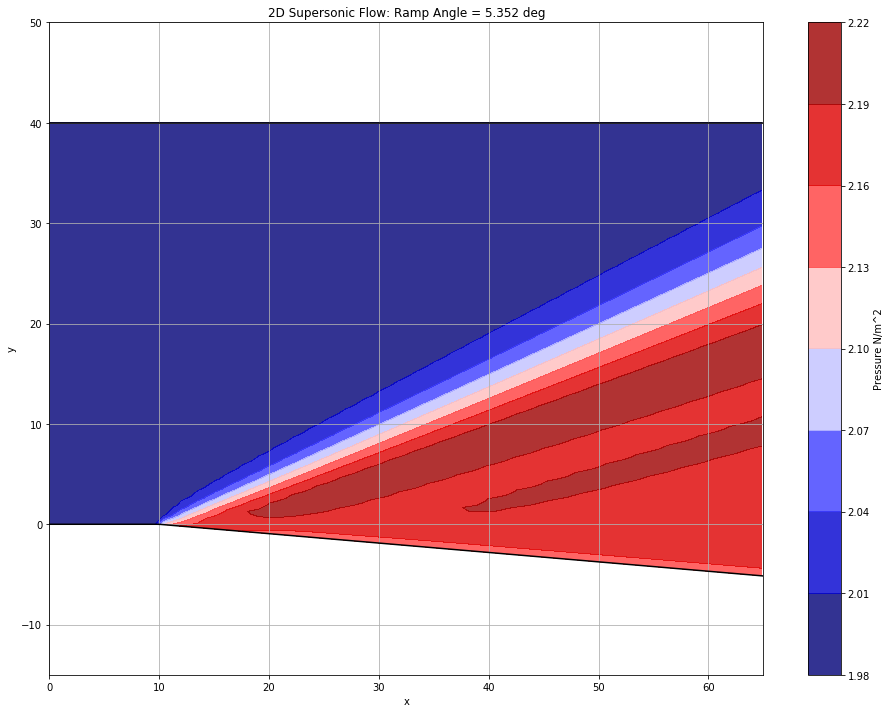

In [29]:
#plot geometry
plt.figure(figsize=(16,12))
plt.plot(x,np.ones(200)*40,'black')
plt.plot(x,40-h,'black')
plt.ylim([-15,50])
plt.xlim([0,65])
plt.grid()
plt.title('2D Supersonic Flow: Ramp Angle = 5.352 deg')
plt.xlabel('x')
plt.ylabel('y')

# Plot Results
plt.contourf(xMatrix, yValues, mach,cmap=plt.cm.seismic, alpha=0.8) 
plt.colorbar(label='Pressure N/m^2')